# Advanced Circuits

In [11]:
import numpy as np
from qiskit import *

## Opaque gates

In [12]:
from qiskit.circuit import Gate

lg_gate = Gate(name='lg_gate', num_qubits=2, params=[])

In [13]:
qr = QuantumRegister(3, 'q')
circ = QuantumCircuit(qr)
circ.append(lg_gate, [qr[0], qr[1]])
circ.append(lg_gate, [qr[1], qr[2]])

circ.draw()

┌──────────┐            
q_0: ┤0         ├────────────
     │  lg_gate │┌──────────┐
q_1: ┤1         ├┤0         ├
     └──────────┘│  lg_gate │
q_2: ────────────┤1         ├
                 └──────────┘

## Composite Gates

In [33]:
# Build sub-circuit
sub_q = QuantumRegister(2)
sub_circ = QuantumCircuit(sub_q, name='sub_circ')
sub_circ.h(sub_q[0])
sub_circ.crz(1, sub_q[0], sub_q[1])
sub_circ.barrier()
sub_circ.id(sub_q[1])
sub_circ.u(1, 2, -2, sub_q[0])

sub_circ.draw()

┌───┐          ░ ┌───────────┐
q5_0: ┤ H ├────■─────░─┤ U(1,2,-2) ├
      └───┘┌───┴───┐ ░ └───┬───┬───┘
q5_1: ─────┤ Rz(1) ├─░─────┤ I ├────
           └───────┘ ░     └───┘

In [35]:
# Convert to a gate & stick it into an arb. place in larger circuit
sub_inst = sub_circ.to_instruction()

qr = QuantumRegister(3, 'q')
circ = QuantumCircuit(qr)
circ.h(qr[0])
circ.cx(qr[0], qr[1])
circ.cx(qr[1], qr[2])
circ.append(sub_inst, [qr[1], qr[2]])

circ.draw()

┌───┐                       
q_0: ┤ H ├──■────────────────────
     └───┘┌─┴─┐     ┌───────────┐
q_1: ─────┤ X ├──■──┤0          ├
          └───┘┌─┴─┐│  sub_circ │
q_2: ──────────┤ X ├┤1          ├
               └───┘└───────────┘

In [36]:
decomposed_circ = circ.decompose() # Doesn't modify original
decomposed_circ.draw()

┌─────────┐                                        
q_0: ┤ U2(0,π) ├──■─────────────────────────────────────
     └─────────┘┌─┴─┐     ┌───┐          ░ ┌───────────┐
q_1: ───────────┤ X ├──■──┤ H ├────■─────░─┤ U(1,2,-2) ├
                └───┘┌─┴─┐└───┘┌───┴───┐ ░ └───┬───┬───┘
q_2: ────────────────┤ X ├─────┤ Rz(1) ├─░─────┤ I ├────
                     └───┘     └───────┘ ░     └───┘

## Parameterized circuits

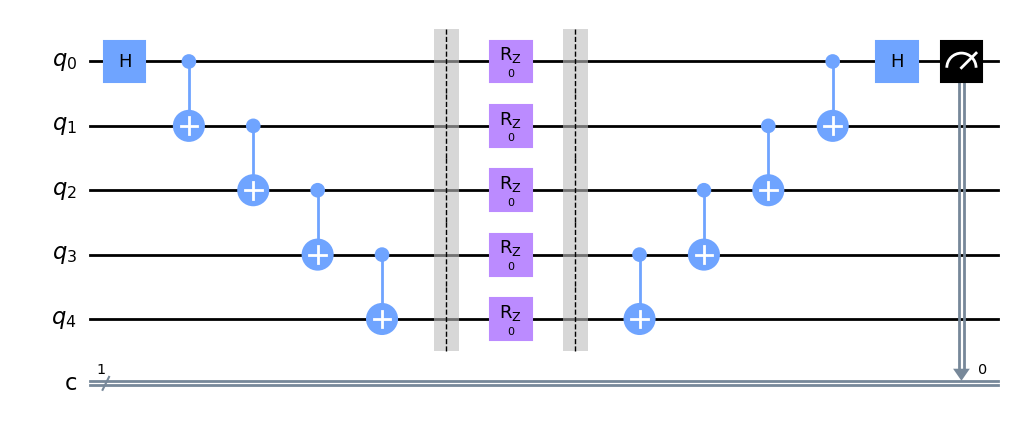

In [43]:
from qiskit.circuit import Parameter

theta = Parameter('0')

n = 5

qc = QuantumCircuit(5, 1)

qc.h(0)

for i in range(n - 1):
    qc.cx(i, i + 1)

qc.barrier()
qc.rz(theta, range(5))
qc.barrier()

for i in reversed(range(n - 1)):
    qc.cx(i, i + 1)
qc.h(0)
qc.measure(0, 0)
# qc.measure(1, 1)

qc.draw('mpl')

In [45]:
print(qc.parameters)

ParameterView([Parameter(0)])


### Binding parameters

All circuit parameters must be bound before sending the circuit to a backend.

In [51]:
theta_range = np.linspace(0, 2 * np.pi, 128)

circuits = [qc.bind_parameters({theta:theta_val})
            for theta_val in theta_range]

circuits[-1].draw()

┌───┐                     ░ ┌────────┐ ░                     ┌───┐┌─┐
q_0: ┤ H ├──■──────────────────░─┤ Rz(2π) ├─░──────────────────■──┤ H ├┤M├
     └───┘┌─┴─┐                ░ ├────────┤ ░                ┌─┴─┐└───┘└╥┘
q_1: ─────┤ X ├──■─────────────░─┤ Rz(2π) ├─░─────────────■──┤ X ├──────╫─
          └───┘┌─┴─┐           ░ ├────────┤ ░           ┌─┴─┐└───┘      ║ 
q_2: ──────────┤ X ├──■────────░─┤ Rz(2π) ├─░────────■──┤ X ├───────────╫─
               └───┘┌─┴─┐      ░ ├────────┤ ░      ┌─┴─┐└───┘           ║ 
q_3: ───────────────┤ X ├──■───░─┤ Rz(2π) ├─░───■──┤ X ├────────────────╫─
                    └───┘┌─┴─┐ ░ ├────────┤ ░ ┌─┴─┐└───┘                ║ 
q_4: ────────────────────┤ X ├─░─┤ Rz(2π) ├─░─┤ X ├─────────────────────╫─
                         └───┘ ░ └────────┘ ░ └───┘                     ║ 
c: 1/═══════════════════════════════════════════════════════════════════╩═
                                                                        0

In [52]:
backend = BasicAer.get_backend('qasm_simulator')
job = backend.run(transpile(circuits, backend))
counts = job.result().get_counts()

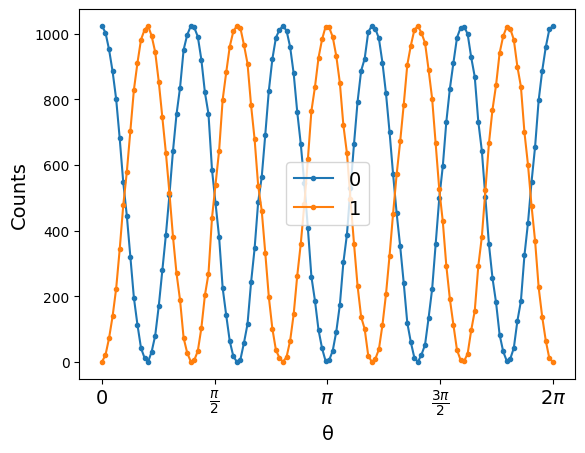

In [53]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

ax.plot(theta_range, list(map(lambda c: c.get('0', 0), counts)), '.-', label='0')
ax.plot(theta_range, list(map(lambda c: c.get('1', 0), counts)), '.-', label='1')

ax.set_xticks([i * np.pi / 2 for i in range(5)])
ax.set_xticklabels(['0', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2\pi$'], fontsize=14)
ax.set_xlabel('θ', fontsize=14)
ax.set_ylabel('Counts', fontsize=14)
ax.legend(fontsize=14)

### Reducing compilation cost

In [61]:
import time
from itertools import combinations
from qiskit.compiler import assemble
from qiskit.providers.fake_provider import FakeVigo

start = time.time()
qcs = []

theta_range = np.linspace(0, 2 * np.pi, 32)

for n in theta_range:
    qc = QuantumCircuit(5)
    
    for k in range(8):
        for i, j in combinations(range(5), 2):
            qc.cx(i, j)
        qc.rz(n, range(5))
        for i, j in combinations(range(5), 2):
            qc.cx(i, j)
    qcs.append(qc)

compiled_circuits = transpile(qcs, backend=FakeVigo())
qobj = assemble(compiled_circuits, backend=FakeVigo())

end = time.time()
print(f'Compiling time = {end - start}')
                                 

Compiling time = 3.6185452938079834


In [62]:
start = time.time()
qc = QuantumCircuit(5)
theta = Parameter('theta')

for k in range(8):
    for i, j in combinations(range(5), 2):
        qc.cx(i, j)
    qc.rz(theta, range(5))
    for i, j in combinations(range(5), 2):
        qc.cx(i, j)
transpiled_qc = transpile(qc, backend=FakeVigo())
qobj = assemble([transpiled_qc.bind_parameters({theta: n})
                for n in theta_range], backend=FakeVigo())
end = time.time()
print(f'Compiling time = {end - start}')

Compiling time = 0.5858922004699707


## Composition

Parameterized circuits can be composed like standard `QuantumCircuits`. Union of 2 parameterized circuits is parameterised by union of 2 parameters.

In [65]:
phi = Parameter('phi')

sub_qc1 = QuantumCircuit(2, name='sc1')
sub_qc1.rz(phi, 0)
sub_qc1.rx(phi, 1)

sub_qc2 = QuantumCircuit(2, name='sc2')
sub_qc2.rx(phi, 0)
sub_qc2.rz(phi, 1)

qc = QuantumCircuit(4)
qr = qc.qregs[0]

qc.append(sub_qc1.to_instruction(), [qr[0], qr[1]])
qc.append(sub_qc2.to_instruction(), [qr[0], qr[1]])

qc.append(sub_qc2.to_instruction(), [qr[2], qr[3]])

print(qc.draw())

     ┌───────────┐┌───────────┐
q_0: ┤0          ├┤0          ├
     │  sc1(phi) ││  sc2(phi) │
q_1: ┤1          ├┤1          ├
     ├───────────┤└───────────┘
q_2: ┤0          ├─────────────
     │  sc2(phi) │             
q_3: ┤1          ├─────────────
     └───────────┘             


To insert sub-circuit with diff. paramterization, `to_instruction` method accepts a kwarg (`parameter_map`). This generated instructions with the source param replaced by new param.

In [68]:
p = Parameter('p')
qc = QuantumCircuit(3, name='oracle')
qc.rz(p, 0)
qc.cx(0, 1)
qc.rz(p, 1)
qc.cx(1, 2)
qc.rz(p, 2)

theta = Parameter('theta')
phi = Parameter('phi')
gamma = Parameter('gamma')

qr = QuantumRegister(9)
larger_qc = QuantumCircuit(qr)
larger_qc.append(qc.to_instruction({p: theta}), qr[0:3])
larger_qc.append(qc.to_instruction({p: phi}), qr[3:6])
larger_qc.append(qc.to_instruction({p: gamma}), qr[6:9])

print(larger_qc.draw())
print(larger_qc.decompose().draw())

       ┌────────────────┐
q12_0: ┤0               ├
       │                │
q12_1: ┤1 oracle(theta) ├
       │                │
q12_2: ┤2               ├
       └┬──────────────┬┘
q12_3: ─┤0             ├─
        │              │ 
q12_4: ─┤1 oracle(phi) ├─
        │              │ 
q12_5: ─┤2             ├─
       ┌┴──────────────┴┐
q12_6: ┤0               ├
       │                │
q12_7: ┤1 oracle(gamma) ├
       │                │
q12_8: ┤2               ├
       └────────────────┘
       ┌───────────┐                                    
q12_0: ┤ Rz(theta) ├──■─────────────────────────────────
       └───────────┘┌─┴─┐┌───────────┐                  
q12_1: ─────────────┤ X ├┤ Rz(theta) ├──■───────────────
                    └───┘└───────────┘┌─┴─┐┌───────────┐
q12_2: ───────────────────────────────┤ X ├┤ Rz(theta) ├
        ┌─────────┐                   └───┘└───────────┘
q12_3: ─┤ Rz(phi) ├───■─────────────────────────────────
        └─────────┘ ┌─┴─┐ ┌─────────┐             